# packages

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

# settings

In [11]:
# default column number pandas
pd.options.display.max_columns = 200

# plot style
sns.set(palette = "colorblind", font_scale = 1.5)

# data

In [16]:
hpi = pd.read_excel("/Users/nicholasmichalak/sandbox/hpi-analysis/data/HPI_AT_BDL_cbsa.xlsx", skiprows = 6)

# better column names
## function
def adjust_colname(x: str, to_replace: dict):
    for s, r in to_replace.items():
        # replace
        x = x.replace(s, r)
    return x.lower()

# replace names
hpi.columns = [adjust_colname(col, {" ": "_", "%": "pct", "(": "", ")": ""}) for col in hpi.columns]

# see it
hpi

,cbsa,name,year,annual_change_pct,hpi,hpi_with_1990_base,hpi_with_2000_base
0,1,Alabama(non CBSA areas),1985,.,100.00,91.76,63.20
1,1,Alabama(non CBSA areas),1986,5.89,105.89,97.16,66.92
2,1,Alabama(non CBSA areas),1987,0.78,106.71,97.92,67.44
3,1,Alabama(non CBSA areas),1988,-0.49,106.19,97.44,67.11
4,1,Alabama(non CBSA areas),1989,5.04,111.55,102.35,70.49
...,...,...,...,...,...,...,...
39669,49780,"Zanesville, OH",2017,3.44,278.12,200.33,119.62
39670,49780,"Zanesville, OH",2018,6.62,296.54,213.60,127.54
39671,49780,"Zanesville, OH",2019,4.51,309.92,223.24,133.30
39672,49780,"Zanesville, OH",2020,3.45,320.61,230.93,137.89


# create 5-year HPI intervals for Boulder County

In [39]:
# interval
interval_length = 5

# name
cbsa_name = "Boulder, CO"

# container
hpi_change_x_year = {"cbsa_name": [], "year_start": [], "year_end": [], "hpi_start": [], "hpi_end": [], "change_frac": [], "annual_change_frac": []}

for year_start_i in tqdm.tqdm(sorted(hpi.query(f"name == '{cbsa_name}'")["year"].unique())):
    # year end
    year_end_i = year_start_i + interval_length

    if year_end_i <= hpi.query("name == 'Boulder, CO'")["year"].max():

        # hpi start
        hpi_start_i = hpi.query(f"(name == 'Boulder, CO') & (year == {year_start_i})")["hpi"].astype(float).squeeze()

        # hpi end
        hpi_end_i = hpi.query(f"(name == 'Boulder, CO') & (year == {year_end_i})")["hpi"].astype(float).squeeze()

        # change fraction
        change_frac_i = (hpi_end_i - hpi_start_i) / hpi_start_i

        # anualized change fraction
        annual_change_frac_i = (hpi_end_i / hpi_start_i) ** (1 / interval_length) - 1.0

        # append
        hpi_change_x_year["cbsa_name"].append(cbsa_name)
        hpi_change_x_year["year_start"].append(year_start_i)
        hpi_change_x_year["year_end"].append(year_end_i)
        hpi_change_x_year["hpi_start"].append(hpi_start_i)
        hpi_change_x_year["hpi_end"].append(hpi_end_i)
        hpi_change_x_year["change_frac"].append(change_frac_i)
        hpi_change_x_year["annual_change_frac"].append(annual_change_frac_i)

# data frame
hpi_change_x_year = pd.DataFrame(hpi_change_x_year)

# see it
hpi_change_x_year

100%|██████████| 47/47 [00:02<00:00, 22.46it/s]


,cbsa_name,year_start,year_end,hpi_start,hpi_end,change_frac,annual_change_frac
0,"Boulder, CO",1975,1980,100.00,190.05,0.900500,0.137034
1,"Boulder, CO",1976,1981,110.32,203.59,0.845450,0.130370
2,"Boulder, CO",1977,1982,130.35,233.16,0.788723,0.123333
3,"Boulder, CO",1978,1983,152.59,229.90,0.506652,0.085432
4,"Boulder, CO",1979,1984,175.72,236.83,0.347769,0.061508
5,"Boulder, CO",1980,1985,190.05,243.55,0.281505,0.050858
6,"Boulder, CO",1981,1986,203.59,248.15,0.218871,0.040379
7,"Boulder, CO",1982,1987,233.16,249.93,0.071925,0.013988
8,"Boulder, CO",1983,1988,229.90,252.48,0.098217,0.018914
9,"Boulder, CO",1984,1989,236.83,257.13,0.085715,0.016584


## plot

''

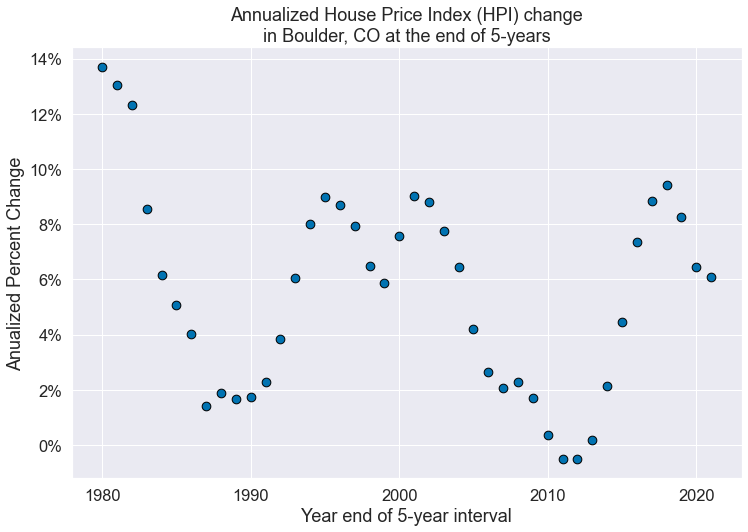

In [46]:
# figure and axes
fig, axes = plt.subplots(figsize = (10.5, 7.5))

# scatterplot
axes.scatter(hpi_change_x_year["year_end"], hpi_change_x_year["annual_change_frac"], s = 75, edgecolor = "black")

# axes format
axes.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1, decimals = 0))

# titles
axes.set(xlabel = f"Year end of {interval_length}-year interval", ylabel = "Anualized Percent Change", title = f"Annualized House Price Index (HPI) change\nin {cbsa_name} at the end of {interval_length}-years")

# tighten layout
fig.tight_layout()
;